# Modelltrainingsmöglichkeit für Schweißkurven

## Format der Input-Files der Schweißkurven
1. XML-Bereich (Zeile 1–45 vor #CSV-START#):
- Enthält XML-Schlüssel–Wert-Paare.
- Jede Information ist in einem eigenen Tag eingeschlossen, z. B.:
- <TimeStamp>DT#2023-09-26-10:26:07</TimeStamp>
2. Trenner (ab Zeile 46 #CSV-START#):
- Markiert den Beginn des eigentlichen Messdatenbereichs.
- Ab dieser Zeile liegt ein reguläres CSV-Format vor.
3. Messdaten-Bereich (ab Zeile 46):
- Erste Zeile: Spaltenüberschriften.
- Danach folgen tabellarische Datenzeilen mit Messwerten.

---

## Format der Input-Files der Zugfestigkeit:
Format Excel-Dateien: \
**Spalten**: \
1.Schweißkurve
- Ganzzahlige IDs (z. B. 1569, 1570, 1571, ...)
- Dient als Schlüssel zur Zuordnung der Zugfestigkeitsdatei zu den einzelnen Schweißkurven
2. Zugfestigkeit
- Ganzzahliger Wert (z. B. 2600, 2750, 2770, …)
- Ergebniswert aus dem Zugversuch in Newton

---

## Formatanforderungen für den weiteren Python-Code 
Um die folgenden Modelle trainiern zu können, müssen die Rohdaten in das folgende Format gebracht werden:
1. zugversuche: DataFrame mit Spalten
- **nr:** Versuchsnummer
- **festigkeit:** Zugfestigkeit
- **label:** Numerische Werte für die zugehörigen klassifizierten Defekt- bzw. Gutschweißungen (Bsp.: 0 = Gutschweißung, 1 = Terminalversatz, ...)
- **label_name:** Klassentyp wie ok-Schweißung oder Terminalversatz 
- **key:** Eindeutiger Schlüssel "Schweißungstyp" + "nr" (Kann beliebig gewählt werden, muss aber mit den Schlüsseln der Kurven übereinstimmen).
---
2. kurven: dict[str, DataFrame] mit:
- Schlüsselnamen wie beispielsweise „ok_1234” oder „kurve_123” repräsentieren einen Dataframe für eine Schweißkurve.
- Die Spalten dieser DataFrames müssen die folgenden Werte enthalten:  
    - **`ms`**: Zeit in Millisekunden  
    - **`power`**: Leistung in Watt  
    - **`force`**: Kraft in Newton  
    - **`dist`**: Distanz in Millimetern 

**Hier folgen ein paar anschauliche Beipiele wie die beiden Datenformate auszusehen haben:** 

In [1]:
"""Import der Packete"""

import io, os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import random
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import kurtosis, skew, mode
from sklearn import model_selection, metrics, manifold
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from helper import Subsample, TsMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import prettytable

2025-11-21 18:42:34.301322: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-21 18:42:34.301782: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 18:42:34.345889: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 18:42:35.186012: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [2]:
"""Einlesen der Beipieldaten"""


def special_read_csv(path):
    """
    Einlesen der Schweisskurvendaten.
    Die CSV-Datei beginnt nach Zeile #CSV-START#.
    """
    res = list()
    flag = False
    for line in open(path):
        if line.strip() == "#CSV-START#":
            flag = True
            continue
        if flag:
            res.append(line)
    stream = io.StringIO("\n".join(res))
    df = pd.read_csv(stream, sep=";")
    df.columns = ["ms", "power", "force", "dist"]
    return df


def collect_schweisskurven_data(base_path, special_read_csv):
    """Einlesen der Schweißkurvendaten"""

    # Nur für die spätere Key-Umbenennung
    key_mapping = {
        "Gutschweißungen": "OK-Schweißung",
        "(Nicht) OK-Schweißungen - Sontrodeneinsätze gewechselt": "NEAR-OK-Sonotrodenwechsel",
        "Nicht OK-Schweißungen - Öl auf Terminal": "Öl auf Terminal",
        "Nicht OK-Schweißungen - Leitungsversatz": "Leitungsversatz",
        "Nicht OK-Schweißungen - Terminalversatz": "Terminalversatz",
    }

    data_dict = {}
    rohdaten_path = os.path.join(base_path, "Rohdaten")

    for dirpath, dirnames, filenames in os.walk(rohdaten_path):
        if "Schweißkurven" in os.path.basename(dirpath):
            parent_folder = os.path.basename(os.path.dirname(dirpath))

            for file in filenames:
                if file.lower().endswith(".csv"):
                    file_path = os.path.join(dirpath, file)
                    df = special_read_csv(file_path)

                    # Nummernextraktion abhängig vom tatsächlichen Ordnernamen
                    if parent_folder == "Gutschweißungen":
                        match = re.search(r"_(\d{4})_", file)
                        number = match.group(1) if match else "unknown"
                    else:
                        match = re.search(r"\d+", file)
                        number = match.group(0) if match else "unknown"

                    # Ordnername für Key ggf. umbenennen
                    mapped_name = key_mapping.get(parent_folder, parent_folder)

                    # Key zusammensetzen
                    key = f"{mapped_name}_{number}"

                    # Eindeutigkeit sicherstellen
                    if key in data_dict:
                        i = 2
                        while f"{key}_{i}" in data_dict:
                            i += 1
                        key = f"{key}_{i}"

                    data_dict[key] = df

    return data_dict


def collect_zugversuch_data(base_path):
    """Einlesen aller Zugversuchsdaten (Excel) und Rückgabe eines kombinierten DataFrames"""
    key_mapping = {
        "Gutschweißungen": "OK-Schweißung",
        "(Nicht) OK-Schweißungen - Sontrodeneinsätze gewechselt": "NEAR-OK-Sonotrodenwechsel",
        "Nicht OK-Schweißungen - Öl auf Terminal": "Öl auf Terminal",
        "Nicht OK-Schweißungen - Leitungsversatz": "Leitungsversatz",
        "Nicht OK-Schweißungen - Terminalversatz": "Terminalversatz",
    }

    dfs = []
    rohdaten_path = os.path.join(base_path, "Rohdaten")

    for dirpath, dirnames, filenames in os.walk(rohdaten_path):
        if "Zugversuche" in os.path.basename(dirpath):
            parent_folder = os.path.basename(os.path.dirname(dirpath))
            mapped_name = key_mapping.get(parent_folder, parent_folder)

            for file in filenames:
                if file.lower().endswith((".xlsx", ".xls")):
                    file_path = os.path.join(dirpath, file)
                    df = pd.read_excel(file_path)
                    df["label_name"] = f"{mapped_name}"

                    dfs.append(df)

    if dfs:
        dfs = pd.concat(dfs, ignore_index=True)
        encoder = LabelEncoder().fit(dfs["label_name"])
        dfs["label"] = encoder.transform(dfs["label_name"])
        dfs["key"] = dfs["label_name"] + "_" + dfs["Schweißkurve"].astype(str)

        dfs.columns = ["nr", "festigkeit", "label_name", "label", "key"]
        dfs = dfs.sort_values("nr", ascending=True)
        return dfs
    else:
        return pd.DataFrame()


def train_test_data(data):
    versuche_train, versuche_test = train_test_split(
        data, train_size=0.8, test_size=0.2, random_state=42
    )
    return versuche_train, versuche_test


"""Ausführung"""
base_path = os.getcwd()
kurven = collect_schweisskurven_data(base_path, special_read_csv)
zugversuche = collect_zugversuch_data(base_path)
versuche_train, versuche_test = train_test_data(zugversuche)

In [3]:
"""Beipiel für den Aufbau des Datensatzes zugversuche"""

zugversuche.head(5)

,nr,festigkeit,label_name,label,key
100,1569,2600.0,OK-Schweißung,2,OK-Schweißung_1569
101,1570,2750.0,OK-Schweißung,2,OK-Schweißung_1570
102,1571,2770.0,OK-Schweißung,2,OK-Schweißung_1571
103,1572,2660.0,OK-Schweißung,2,OK-Schweißung_1572
104,1573,2810.0,OK-Schweißung,2,OK-Schweißung_1573


In [4]:
"""Drei Beispiele für den Aufbau der Kurven-Daten"""

kurven_subset = {k: kurven[k] for k in random.sample(list(kurven.keys()), 3)}
kurven_subset

{'OK-Schweißung_1589':         ms    power    force  dist
 0        1     0.00    0.000  0.00
 1        2     0.00  506.607  0.00
 2        3     0.00  506.607  0.00
 3        4     0.00  506.607  0.00
 4        5     0.00  506.607  0.00
 ...    ...      ...      ...   ...
 1598  1599  2133.40  557.878  2.31
 1599  1600  2185.28  532.243  2.31
 1600  1601  2217.63  561.785  2.31
 1601  1602  2232.28  550.066  2.31
 1602  1603  2229.83  540.056  2.31
 
 [1603 rows x 4 columns],
 'Leitungsversatz_2555':         ms    power    force      dist
 0        1     0.00    0.000  0.000000
 1        2     0.00  504.654  0.000000
 2        3     0.00  504.654  0.000000
 3        4     0.00  504.654  0.009995
 4        5     0.00  506.607  0.009995
 ...    ...      ...      ...       ...
 1753  1754  1974.60  567.888  3.420000
 1754  1755  1949.88  591.571  3.420000
 1755  1756  1977.05  557.878  3.420000
 1756  1757  2019.16  559.832  3.420000
 1757  1758  2041.44  583.514  3.420000
 
 [1758 rows 

## Lesen Sie hier Ihre Daten im vorgegebenen Format ein: 

In [5]:
"""Zelle zum Einlesen der Kurven-Daten und der Zugversuch-Datei Ihrer Schweißkurven."""

"""Ausgabe muss „kurven”, „zugversuche” enthalten, damit die weiteren Abschnitte reibungslos funktionieren."""

'Ausgabe muss „kurven”, „zugversuche” enthalten, damit die weiteren Abschnitte reibungslos funktionieren.'

# Klassifikationsmodelle

## Weiterverarbeitung, Training und Evaluation des Klassifikationsmodells 
SVC(C=8286.427728546843, gamma=1.0481131341546852, probability=True)

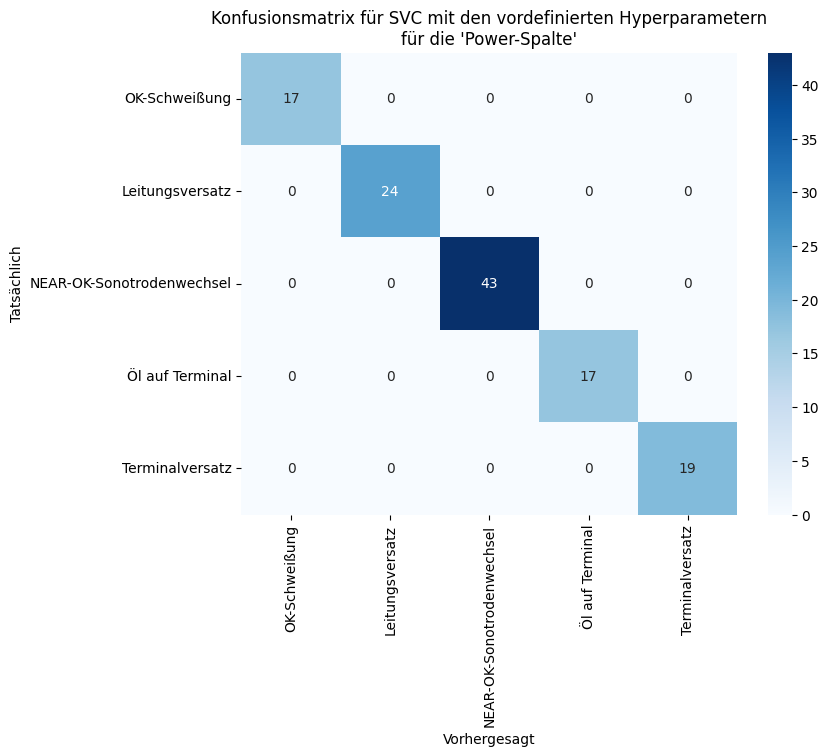

                           precision    recall  f1-score   support

            OK-Schweißung       1.00      1.00      1.00        17
          Leitungsversatz       1.00      1.00      1.00        24
NEAR-OK-Sonotrodenwechsel       1.00      1.00      1.00        43
          Öl auf Terminal       1.00      1.00      1.00        17
          Terminalversatz       1.00      1.00      1.00        19

                 accuracy                           1.00       120
                macro avg       1.00      1.00      1.00       120
             weighted avg       1.00      1.00      1.00       120



In [6]:
subsample = 80  
ts_len = 800  
SCALE = 2000  
subsample = Subsample(subsample, ts_len)
subsample.fit()

versuche_train, versuche_test = model_selection.train_test_split(
    zugversuche, train_size=0.8, test_size=0.2, random_state=42
)
X_train = subsample.transform(versuche_train.key, kurven)
label_train = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values
X_test = subsample.transform(versuche_test.key, kurven)
label_test = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values
festigkeit_train = festigkeit_train / SCALE
festigkeit_test = festigkeit_test / SCALE
tsMaxScale = TsMaxScaler()
tsMaxScale.fit(X_train)
X_train_scaled = tsMaxScale.transform(X_train)
X_test_scaled = tsMaxScale.transform(X_test)


X2_train = X_train_scaled[
    :, :, 0
]  
X2_test = X_test_scaled[
    :, :, 0
]  

model = SVC(C=8286.427728546843, gamma=1.0481131341546852, probability=True)
model.fit(X2_train, label_train)
pred_train = model.predict(X2_train)
pred_test = model.predict(X2_test)

cm = confusion_matrix(label_test, pred_test)

"""Labels aus den Daten"""
labels = versuche_test.label_name.unique()

"""Heatmap der Konfusionsmatrix"""
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
)
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title(
    "Konfusionsmatrix für SVC mit den vordefinierten Hyperparametern\nfür die 'Power-Spalte'"
)
plt.show()
print(classification_report(label_test, pred_test, target_names=labels))

# Klassifikationsmodelle mit statistischen Featuren: 
## Formatanforderungen für die folgenden Klassifikationsmodelle 
In dem folgenden Abschnitt wurden die Werte der Schweißkurven auf verschiedene statistische Maße aggregiert.   
### Aggregierter Datensatz: Beschreibung der Spalten

#### Power-Merkmale (`p_...`)
- **p_mean**: Mittelwert der Power über alle Zeitpunkte je Kurve  
- **p_median**: Median der Power je Kurve  
- **p_std**: Standardabweichung der Power je Kurve  
- **p_max**: Maximale Power je Kurve  
- **p_q25**: 25%-Quantil der Power je Kurve  
- **p_q75**: 75%-Quantil der Power je Kurve  
- **p_iqr_range**: Interquartilsabstand der Power, normiert auf den Gesamtbereich  
- **p_f_ratio**: Verhältnis der gesamten Power-Summe zur gesamten Kraft-Summe  
- **p_d_ratio**: Verhältnis der gesamten Power-Summe zur gesamten Distanz-Summe  
- **p_t_ratio**: Verhältnis der gesamten Power-Summe zur gesamten Zeit-Summe
- **ti**: Stichprobenanzahl

#### Kraft-Merkmale (`f_...`)
- **f_mean**: Mittelwert der Kraft über alle Zeitpunkte je Kurve  
- **f_median**: Median der Kraft je Kurve  
- **f_std**: Standardabweichung der Kraft je Kurve  
- **f_max**: Maximale Kraft je Kurve  
- **f_q25**: 25%-Quantil der Kraft je Kurve  
- **f_q75**: 75%-Quantil der Kraft je Kurve  
- **f_iqr_range**: Interquartilsabstand der Kraft, normiert auf den Gesamtbereich  
- **f_d_ratio**: Verhältnis der gesamten Kraft-Summe zur gesamten Distanz-Summe  
- **f_t_ratio**: Verhältnis der gesamten Kraft-Summe zur gesamten Zeit-Summe  

#### Distanz-Merkmale (`d_...`)
- **d_mean**: Mittelwert der Distanz über alle Zeitpunkte je Kurve  
- **d_median**: Median der Distanz je Kurve  
- **d_std**: Standardabweichung der Distanz je Kurve  
- **d_max**: Maximale Distanz je Kurve  
- **d_q25**: 25%-Quantil der Distanz je Kurve  
- **d_q75**: 75%-Quantil der Distanz je Kurve  
- **d_iqr_range**: Interquartilsabstand der Distanz, normiert auf den Gesamtbereich  
- **d_t_ratio**: Verhältnis der gesamten Distanz-Summe zur gesamten Zeit-Summe  

#### Zeitmerkmale (`t_...`)
- **t_max**: Maximale Zeit (in Millisekunden) je Kurve  
- **t_sum**: Summe aller Zeitpunkte (in Millisekunden) je Kurve
- **t_median**: Median der Zeit (in Millisekunden) je Kurve 
- **t_mean**:Mittelwert der Zeit (in Millisekunden) je Kurve
- **t_std**: Standardabweichung der Zeit (in Millisekunden) je Kurve
- **t_q25**: 25%-Quantil der Zeit (in Millisekunden) je Kurve
- **t_q75**: 75%-Quantil der Zeit (in Millisekunden) je Kurve


#### Schwellenzeitpunkte (`_b50`, `_b75`)
- **p_b50**: Zeit (ms), bei der die Power erstmals mindestens 50 % des Maximalwertes erreicht  
- **p_b75**: Zeit (ms), bei der die Power erstmals mindestens 75 % des Maximalwertes erreicht  
- **f_b50**: Zeit (ms), bei der die Kraft erstmals mindestens 50 % des Maximalwertes erreicht  
- **f_b75**: Zeit (ms), bei der die Kraft erstmals mindestens 75 % des Maximalwertes erreicht  
- **d_b50**: Zeit (ms), bei der die Distanz erstmals mindestens 50 % des Maximalwertes erreicht  
- **d_b75**: Zeit (ms), bei der die Distanz erstmals mindestens 75 % des Maximalwertes erreicht  

#### Zugfestigkeit
- **festigkeit**: Maximale Zugfestigkeit des jeweiligen Experiments (aus den Zugversuchen) 


In [7]:
dfs_list = []
for key, df in kurven.items():
    df = df.copy()
    df["key"] = key
    meta = zugversuche.loc[
        zugversuche["key"] == key, ["nr", "label_name", "label", "festigkeit"]
    ]
    if not meta.empty:
        df["nr"] = meta["nr"].iloc[0]
        df["label_name"] = meta["label_name"].iloc[0]
        df["label"] = meta["label"].iloc[0]
        df["festigkeit"] = meta["festigkeit"].iloc[0]
        dfs_list.append(df)
df = pd.concat(dfs_list, ignore_index=True)
df

,ms,power,force,dist,key,nr,label_name,label,festigkeit
0,1,0.00,0.000,0.00,Öl auf Terminal_2107,2107,Öl auf Terminal,4,0.000000
1,2,0.00,500.748,0.00,Öl auf Terminal_2107,2107,Öl auf Terminal,4,0.000000
2,3,0.00,502.701,0.00,Öl auf Terminal_2107,2107,Öl auf Terminal,4,0.000000
3,4,0.00,500.748,0.00,Öl auf Terminal_2107,2107,Öl auf Terminal,4,0.000000
4,5,0.00,502.701,0.00,Öl auf Terminal_2107,2107,Öl auf Terminal,4,0.000000
...,...,...,...,...,...,...,...,...,...
968330,2070,1840.30,546.159,3.79,Leitungsversatz_2550,2550,Leitungsversatz,0,2371.120117
968331,2071,1857.70,577.654,3.79,Leitungsversatz_2550,2550,Leitungsversatz,0,2371.120117
968332,2072,1889.74,569.842,3.79,Leitungsversatz_2550,2550,Leitungsversatz,0,2371.120117
968333,2073,1904.39,569.842,3.79,Leitungsversatz_2550,2550,Leitungsversatz,0,2371.120117


In [8]:
"""Umwandlung des DataFrames"""

dfs_list = []
for key, df in kurven.items():
    df = df.copy()
    df["key"] = key
    meta = zugversuche.loc[
        zugversuche["key"] == key, ["nr", "label_name", "label", "festigkeit"]
    ]
    if not meta.empty:
        df["nr"] = meta["nr"].iloc[0]
        df["label_name"] = meta["label_name"].iloc[0]
        df["label"] = meta["label"].iloc[0]
        df["festigkeit"] = meta["festigkeit"].iloc[0]
        dfs_list.append(df)
df = pd.concat(dfs_list, ignore_index=True)


df["ms"] = pd.to_numeric(df["ms"], errors="coerce")
df["power"] = pd.to_numeric(df["power"], errors="coerce")
df["force"] = pd.to_numeric(df["force"], errors="coerce")
df["dist"] = pd.to_numeric(df["dist"], errors="coerce")
df["festigkeit"] = pd.to_numeric(df["festigkeit"], errors="coerce")


agg_dict = {
    "power": [
        ("p_mean", "mean"),
        ("p_median", "median"),
        ("p_std", "std"),
        ("p_max", "max"),
        ("p_q25", lambda x: np.quantile(x, 0.25)),
        ("p_q75", lambda x: np.quantile(x, 0.75)),
        (
            "p_iqr_range",
            lambda x: (np.percentile(x, 75) - np.percentile(x, 25))
            / (x.max() - x.min() + 1e-6),
        ),
        ("p_sum", "sum"),
        ("ti", "count"),
    ],
    "force": [
        ("f_mean", "mean"),
        ("f_median", "median"),
        ("f_std", "std"),
        ("f_max", "max"),
        ("f_q25", lambda x: np.quantile(x, 0.25)),
        ("f_q75", lambda x: np.quantile(x, 0.75)),
        (
            "f_iqr_range",
            lambda x: (np.percentile(x, 75) - np.percentile(x, 25))
            / (x.max() - x.min() + 1e-6),
        ),
        ("f_sum", "sum"),
    ],
    "dist": [
        ("d_mean", "mean"),
        ("d_median", "median"),
        ("d_std", "std"),
        ("d_max", "max"),
        ("d_q25", lambda x: np.quantile(x, 0.25)),
        ("d_q75", lambda x: np.quantile(x, 0.75)),
        (
            "d_iqr_range",
            lambda x: (np.percentile(x, 75) - np.percentile(x, 25))
            / (x.max() - x.min() + 1e-6),
        ),
        ("d_sum", "sum"),
    ],
    "ms": [
        ("t_max", "max"),
        ("t_sum", "sum"),
        ("t_median", "median"),
        ("t_mean", "mean"),
        ("t_std", "std"),
        ("t_q25", lambda x: np.quantile(x, 0.25)),
        ("t_q75", lambda x: np.quantile(x, 0.75)),
    ],
}

g = (
    df.groupby(["nr", "label_name", "label"], sort=False)
    .agg(**{new: (col, func) for col, lst in agg_dict.items() for new, func in lst})
    .reset_index()
)

eps = 1e-9
g["p_f_ratio"] = g["p_sum"] / (g["f_sum"] + eps)
g["p_d_ratio"] = g["p_sum"] / (g["d_sum"] + eps)
g["p_t_ratio"] = g["p_sum"] / (g["t_sum"] + eps)
g["f_d_ratio"] = g["f_sum"] / (g["d_sum"] + eps)
g["f_t_ratio"] = g["f_sum"] / (g["t_sum"] + eps)
g["d_t_ratio"] = g["d_sum"] / (g["t_sum"] + eps)
g = g.drop(columns=["p_sum", "f_sum", "d_sum"])

df2 = df.sort_values(["nr", "ms"])
grp = df2.groupby(["nr", "label_name", "label"], sort=False)


def b_at(dfg, col, frac):
    t = frac * dfg[col].max()
    m = dfg[col] >= t
    return dfg.loc[m, "ms"].iloc[0] if m.any() else np.nan


b = grp.apply(
    lambda dfg: pd.Series(
        {
            "p_b50": b_at(dfg, "power", 0.50),
            "p_b75": b_at(dfg, "power", 0.75),
            "f_b50": b_at(dfg, "force", 0.50),
            "f_b75": b_at(dfg, "force", 0.75),
            "d_b50": b_at(dfg, "dist", 0.50),
            "d_b75": b_at(dfg, "dist", 0.75),
        }
    )
).reset_index()

g = g.merge(b, on=["nr", "label_name", "label"], how="left")

df_z = df[["nr", "festigkeit"]].drop_duplicates()
df = g.merge(df_z, on="nr", how="left")

df = df[
    [
        "nr",
        "label_name",
        "label",
        "p_mean",
        "p_median",
        "p_std",
        "p_max",
        "p_q25",
        "p_q75",
        "p_iqr_range",
        "p_f_ratio",
        "p_d_ratio",
        "p_t_ratio",
        "f_mean",
        "f_median",
        "f_std",
        "f_max",
        "f_q25",
        "f_q75",
        "f_iqr_range",
        "f_d_ratio",
        "f_t_ratio",
        "d_mean",
        "d_median",
        "d_std",
        "d_max",
        "d_q25",
        "d_q75",
        "d_iqr_range",
        "d_t_ratio",
        "t_max",
        "t_sum",
        "t_mean",
        "t_median",
        "t_std",
        "t_q25",
        "t_q75",
        "p_b50",
        "p_b75",
        "f_b50",
        "f_b75",
        "d_b50",
        "d_b75",
        "ti",
        "festigkeit",
    ]
]
df.sort_values(by="nr", ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

/tmp/ipykernel_51703/815444474.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  b = grp.apply(


## Modeltraining für die logistische Regression: 
LogisticRegression(C=1.4563484775012439, max_iter=5500, solver="saga")

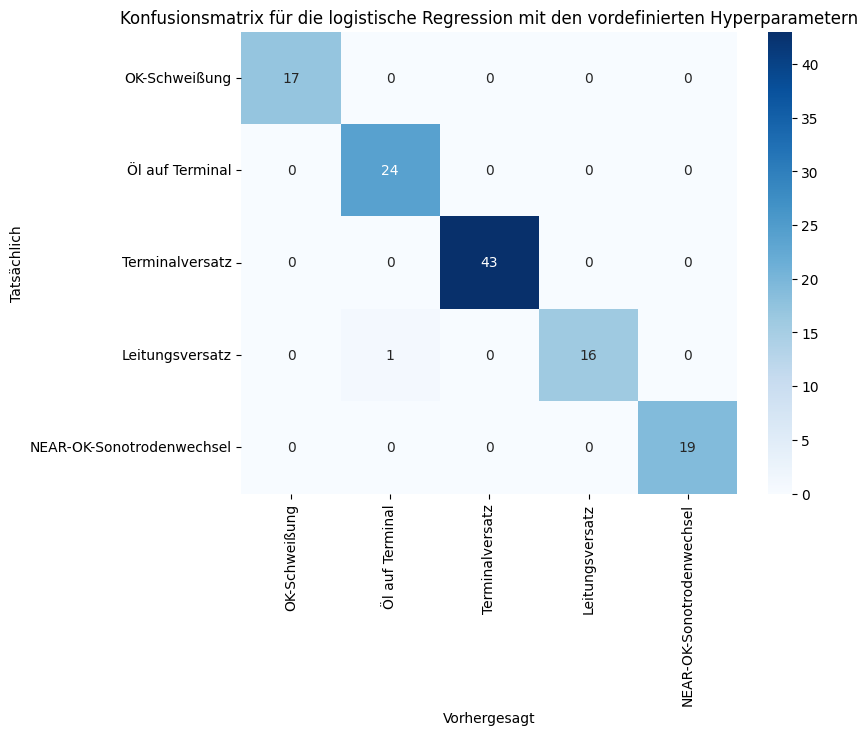

                           precision    recall  f1-score   support

            OK-Schweißung       1.00      1.00      1.00        17
          Öl auf Terminal       0.96      1.00      0.98        24
          Terminalversatz       1.00      1.00      1.00        43
          Leitungsversatz       1.00      0.94      0.97        17
NEAR-OK-Sonotrodenwechsel       1.00      1.00      1.00        19

                 accuracy                           0.99       120
                macro avg       0.99      0.99      0.99       120
             weighted avg       0.99      0.99      0.99       120



In [9]:
"""Filtern des Datensatzes"""

df_used = df[
    [
        "nr",
        "label_name",
        "label",
        "p_max",
        "p_q75",
        "p_median",
        "p_f_ratio",
        "p_q25",
        "p_d_ratio",
        "p_t_ratio",
        "f_t_ratio",
        "f_d_ratio",
        "t_max",
        "p_std",
        "d_std",
    ]
]


y = df_used["label"].values
x = df_used[
    [
        "p_max",
        "p_q75",
        "p_median",
        "p_f_ratio",
        "p_q25",
        "p_d_ratio",
        "p_t_ratio",
        "f_t_ratio",
        "f_d_ratio",
        "t_max",
        "p_std",
        "d_std",
    ]
].values
label = df_used["label"].values
label_name = df_used["label_name"]
x_train, x_test, y_train, y_test, label_train, label_test = (
    model_selection.train_test_split(
        x, y, label, train_size=0.8, test_size=0.2, random_state=42
    )
)

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(x_train)
X_test_scaled = std_scaler.transform(x_test)
model = LogisticRegression(C=1.4563484775012439, max_iter=5500, solver="saga")
model.fit(X_train_scaled, y_train)
pred_test = model.predict(X_test_scaled)

cm = confusion_matrix(y_test, pred_test)

"""Labels aus den Daten"""
labels = df_used["label_name"].unique()

"""Heatmap der Konfusionsmatrix"""
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
)
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title(
    "Konfusionsmatrix für die logistische Regression mit den vordefinierten Hyperparametern"
)
plt.show()
print(classification_report(y_test, pred_test, target_names=labels))

#  Modeltraining für den RandomForest:

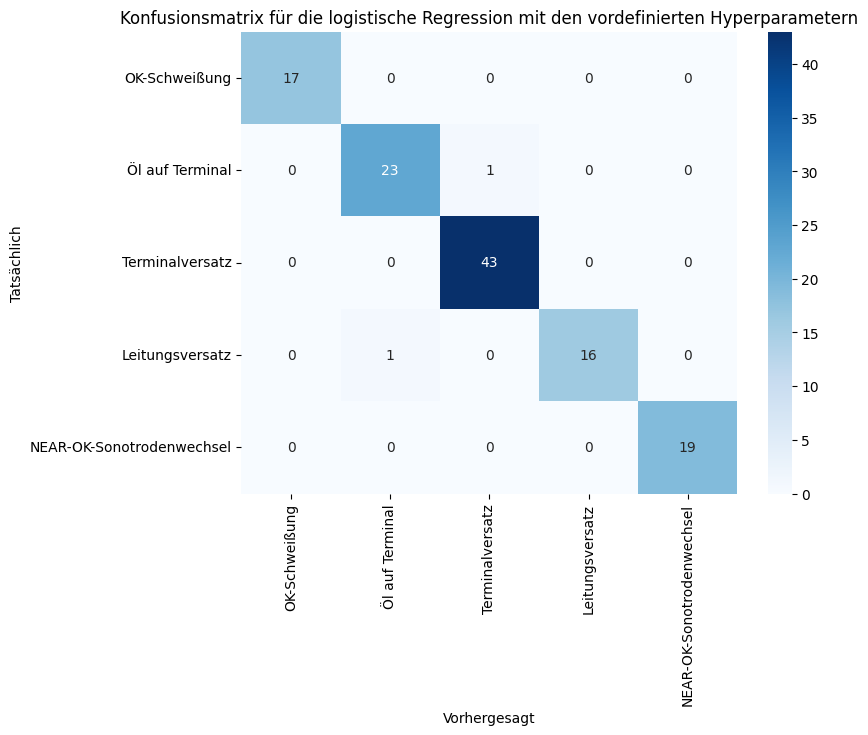

                           precision    recall  f1-score   support

            OK-Schweißung       1.00      1.00      1.00        17
          Öl auf Terminal       0.96      0.96      0.96        24
          Terminalversatz       0.98      1.00      0.99        43
          Leitungsversatz       1.00      0.94      0.97        17
NEAR-OK-Sonotrodenwechsel       1.00      1.00      1.00        19

                 accuracy                           0.98       120
                macro avg       0.99      0.98      0.98       120
             weighted avg       0.98      0.98      0.98       120



In [10]:
"""Filtern des Datensatzes"""

df_used = df[
    [
        "nr",
        "label_name",
        "label",
        "p_max",
        "p_q75",
        "p_median",
        "p_f_ratio",
        "p_q25",
        "p_d_ratio",
        "p_t_ratio",
        "f_t_ratio",
        "f_d_ratio",
        "t_max",
        "p_std",
        "d_std",
    ]
]


y = df_used["label"].values
x = df_used[
    [
        "p_max",
        "p_q75",
        "p_median",
        "p_f_ratio",
        "p_q25",
        "p_d_ratio",
        "p_t_ratio",
        "f_t_ratio",
        "f_d_ratio",
        "t_max",
        "p_std",
        "d_std",
    ]
].values
label = df_used["label"].values
label_name = df_used["label_name"]
x_train, x_test, y_train, y_test, label_train, label_test = (
    model_selection.train_test_split(
        x, y, label, train_size=0.8, test_size=0.2, random_state=42
    )
)

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(x_train)
X_test_scaled = std_scaler.transform(x_test)
model = RandomForestClassifier(
    max_features="log2", n_estimators=500, n_jobs=-1, random_state=42
)
model.fit(X_train_scaled, y_train)
pred_test = model.predict(X_test_scaled)

cm = confusion_matrix(y_test, pred_test)

"""Labels aus den Daten"""
labels = df_used["label_name"].unique()

"""Heatmap der Konfusionsmatrix"""
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
)
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title(
    "Konfusionsmatrix für die logistische Regression mit den vordefinierten Hyperparametern"
)
plt.show()
print(classification_report(y_test, pred_test, target_names=labels))

/home/david/miniconda3/envs/pyenv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1763746961.647058   51703 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1763746961.653935   51703 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


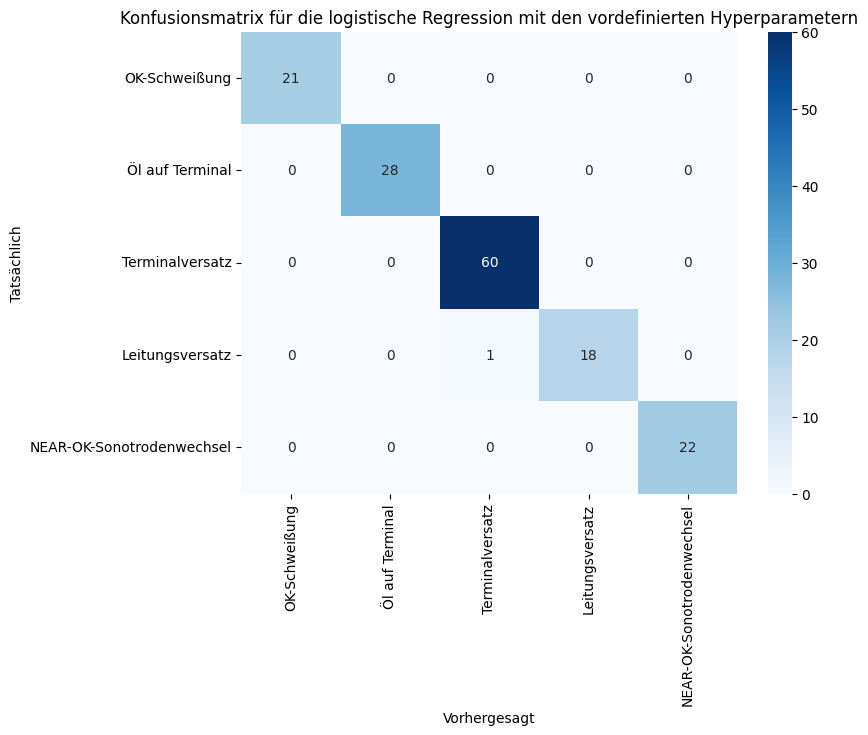

                           precision    recall  f1-score   support

            OK-Schweißung       1.00      1.00      1.00        21
          Öl auf Terminal       1.00      1.00      1.00        28
          Terminalversatz       0.98      1.00      0.99        60
          Leitungsversatz       1.00      0.95      0.97        19
NEAR-OK-Sonotrodenwechsel       1.00      1.00      1.00        22

                 accuracy                           0.99       150
                macro avg       1.00      0.99      0.99       150
             weighted avg       0.99      0.99      0.99       150



In [11]:
"""Filtern des Datensatzes"""
df_used = df[["nr", "label_name", "label", "p_std", "f_max", "t_sum"]]


y = df_used["label"].values
x = df_used[["p_std", "f_max", "t_sum"]].values
label = df_used["label"].values
label_name = df_used["label_name"]
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x,
    y,
    test_size=0.25,
    random_state=42,
)

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(x_train)
X_test_scaled = std_scaler.transform(x_test)


def create_model(optimizer="adam", dropout_rate=0.0, neurons=64):
    model = Sequential()
    model.add(Dense(neurons, activation="relu", input_shape=(x_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons // 2, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(set(y_train)), activation="softmax"))
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


model = KerasClassifier(
    model=create_model,
    batch_size=16,
    epochs=50,
    model__dropout_rate=0.5,
    model__neurons=64,
    model__optimizer="adam",
    verbose=0,
)

model.fit(X_train_scaled, y_train)
pred_test = model.predict(X_test_scaled)

cm = confusion_matrix(y_test, pred_test)

"""Labels aus den Daten"""
labels = df_used["label_name"].unique()

"""Heatmap der Konfusionsmatrix"""
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
)
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title(
    "Konfusionsmatrix für die logistische Regression mit den vordefinierten Hyperparametern"
)
plt.show()
print(classification_report(y_test, pred_test, target_names=labels))

# Modeltraining für KNeighborsClassifier

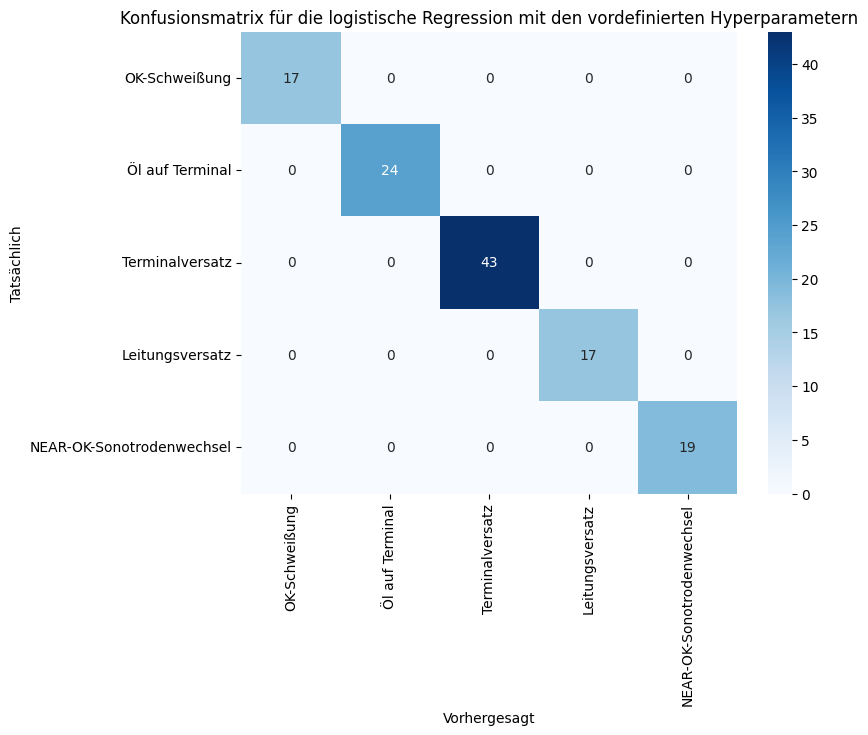

                           precision    recall  f1-score   support

            OK-Schweißung       1.00      1.00      1.00        17
          Öl auf Terminal       1.00      1.00      1.00        24
          Terminalversatz       1.00      1.00      1.00        43
          Leitungsversatz       1.00      1.00      1.00        17
NEAR-OK-Sonotrodenwechsel       1.00      1.00      1.00        19

                 accuracy                           1.00       120
                macro avg       1.00      1.00      1.00       120
             weighted avg       1.00      1.00      1.00       120



In [12]:
"""Filtern des Datensatzes"""

df_used = df[["nr", "label_name", "label", "p_std", "f_max", "t_sum"]]


y = df_used["label"].values
x = df_used[["p_std", "f_max", "t_sum"]].values
label = df_used["label"].values
label_name = df_used["label_name"]
x_train, x_test, y_train, y_test, label_train, label_test = (
    model_selection.train_test_split(
        x, y, label, train_size=0.8, test_size=0.2, random_state=42
    )
)

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(x_train)
X_test_scaled = std_scaler.transform(x_test)
model = KNeighborsClassifier(metric="euclidean", n_neighbors=9, weights="uniform")
model.fit(X_train_scaled, y_train)
pred_test = model.predict(X_test_scaled)

cm = confusion_matrix(y_test, pred_test)

"""Labels aus den Daten"""
labels = df_used["label_name"].unique()

"""Heatmap der Konfusionsmatrix"""
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
)
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title(
    "Konfusionsmatrix für die logistische Regression mit den vordefinierten Hyperparametern"
)
plt.show()
print(classification_report(y_test, pred_test, target_names=labels))

# Modelltraining SVC mit PCA 
SVC(gamma= 0.020235896477251575, C= 1.4563484775012439)

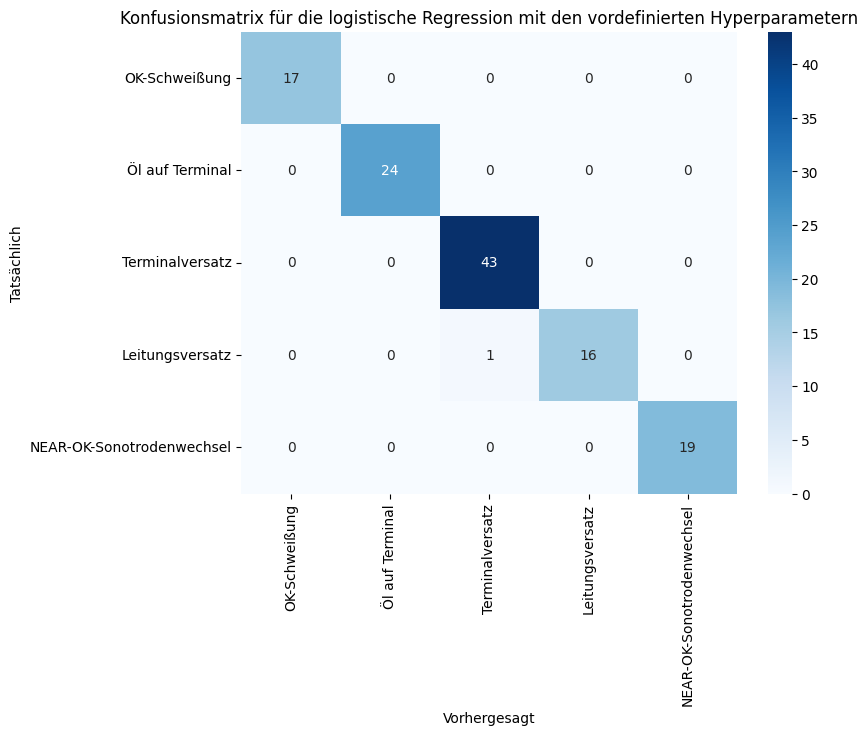

                           precision    recall  f1-score   support

            OK-Schweißung       1.00      1.00      1.00        17
          Öl auf Terminal       1.00      1.00      1.00        24
          Terminalversatz       0.98      1.00      0.99        43
          Leitungsversatz       1.00      0.94      0.97        17
NEAR-OK-Sonotrodenwechsel       1.00      1.00      1.00        19

                 accuracy                           0.99       120
                macro avg       1.00      0.99      0.99       120
             weighted avg       0.99      0.99      0.99       120



In [13]:
filter_x = [
    "p_mean",
    "p_q25",
    "p_median",
    "p_q75",
    "p_max",
    "p_std",
    "p_b50",
    "p_b75",
    "f_mean",
    "f_q25",
    "f_median",
    "f_q75",
    "f_max",
    "f_std",
    "f_b50",
    "f_b75",
    "d_mean",
    "d_q25",
    "d_median",
    "d_q75",
    "d_max",
    "d_std",
    "d_b50",
    "d_b75",
    "t_max",
]


df_used = df[
    [
        "nr",
        "label_name",
        "label",
        "p_mean",
        "p_q25",
        "p_median",
        "p_q75",
        "p_max",
        "p_std",
        "p_b50",
        "p_b75",
        "f_mean",
        "f_q25",
        "f_median",
        "f_q75",
        "f_max",
        "f_std",
        "f_b50",
        "f_b75",
        "d_mean",
        "d_q25",
        "d_median",
        "d_q75",
        "d_max",
        "d_std",
        "d_b50",
        "d_b75",
        "t_max",
    ]
]


y = df_used["label"].values
x = df_used[filter_x].values

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x, y, test_size=0.2, random_state=42
)

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(x_train)
X_test_scaled = std_scaler.transform(x_test)

pca_scaled = PCA(n_components=10)
# nur relevante Features (cor. bzgl. Festigkeit ≥ 0.1)
# pca_scaled = decomposition.PCA(n_components=8)
Z_train_scaled = pca_scaled.fit_transform(X_train_scaled)
Z_test_scaled = pca_scaled.transform(X_test_scaled)

model = SVC(gamma=0.020235896477251575, C=1.4563484775012439)
model.fit(Z_train_scaled, y_train)
pred_test = model.predict(Z_test_scaled)


cm = confusion_matrix(y_test, pred_test)

"""Labels aus den Daten"""
labels = df_used["label_name"].unique()

"""Heatmap der Konfusionsmatrix"""
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
)
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title(
    "Konfusionsmatrix für die logistische Regression mit den vordefinierten Hyperparametern"
)
plt.show()
print(classification_report(y_test, pred_test, target_names=labels))

# Regressionsmodelle 
KNeighborsRegressor(weights="uniform", p=2, n_neighbors=8, metric="minkowski") 

In [14]:
df_used = df[["nr", "festigkeit", "p_std", "f_max", "t_sum"]]
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
)
from prettytable import PrettyTable
from sklearn.neighbors import KNeighborsRegressor

y = df_used["festigkeit"].values
x = df_used[["p_std", "f_max", "t_sum"]].values


(
    x_train,
    x_test,
    y_train,
    y_test,
) = model_selection.train_test_split(
    x, y, train_size=0.8, test_size=0.2, random_state=42
)

x_std_scaler = StandardScaler()
y_std_scaler = StandardScaler()
X_train_scaled = x_std_scaler.fit_transform(x_train)
X_test_scaled = x_std_scaler.transform(x_test)
y_train_scaled = y_std_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_std_scaler.transform(y_test.reshape(-1, 1))
model = KNeighborsRegressor(weights="uniform", p=2, n_neighbors=8, metric="minkowski")
model.fit(X_train_scaled, y_train_scaled)
pred_test = model.predict(X_test_scaled)
pred_test = y_std_scaler.inverse_transform(pred_test)
# Berechnen der Metriken
r2 = r2_score(y_test, pred_test)
mae = mean_absolute_error(y_test, pred_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_test))
table = PrettyTable()
table.field_names = ["R²", "MAE", "RSME"]
table.add_row([round(r2, 3), round(mae, 3), round(rmse, 3)])
print(table)

+-------+-------+---------+
|   R²  |  MAE  |   RSME  |
+-------+-------+---------+
| 0.975 | 97.83 | 152.158 |
+-------+-------+---------+


# MLP Regressor 

In [15]:
from sklearn.neural_network import MLPRegressor

filter_x = [
    "p_mean",
    "d_mean",
    "t_mean",
    "p_median",
    "f_median",
    "d_median",
    "t_median",
    "p_std",
    "f_std",
    "d_std",
    "t_std",
    "p_max",
    "f_max",
    "d_max",
    "t_max",
    "t_sum",
    "p_q25",
    "f_q25",
    "d_q25",
    "t_q25",
    "p_q75",
    "f_q75",
    "d_q75",
    "t_q75",
]
df_used = df[
    [
        "nr",
        "festigkeit",
        "p_mean",
        "d_mean",
        "t_mean",
        "p_median",
        "f_median",
        "d_median",
        "t_median",
        "p_std",
        "f_std",
        "d_std",
        "t_std",
        "p_max",
        "f_max",
        "d_max",
        "t_max",
        "t_sum",
        "p_q25",
        "f_q25",
        "d_q25",
        "t_q25",
        "p_q75",
        "f_q75",
        "d_q75",
        "t_q75",
    ]
]
y = df_used["festigkeit"].values
x = df_used[filter_x].values


(
    x_train,
    x_test,
    y_train,
    y_test,
) = model_selection.train_test_split(
    x,
    y,
    train_size=0.8,
    test_size=0.2,
    random_state=42,
)

x_std_scaler = StandardScaler()
y_std_scaler = StandardScaler()
X_train_scaled = x_std_scaler.fit_transform(x_train)
X_test_scaled = x_std_scaler.transform(x_test)
y_train_scaled = y_std_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_std_scaler.transform(y_test.reshape(-1, 1))
pca = PCA(n_components=4)
x_train_transformed = pca.fit_transform(X_train_scaled)
x_test_transformed = pca.transform(X_test_scaled)

model = MLPRegressor(
    tol=0.001,
    solver="lbfgs",
    max_iter=10000,
    hidden_layer_sizes=(64,),
    alpha=1e-4,
    activation="tanh",
    random_state=42,
)

model.fit(x_train_transformed, y_train_scaled)
pred_test = model.predict(x_test_transformed)

pred_test = y_std_scaler.inverse_transform(pred_test.reshape(-1, 1))

# Berechnen der Metriken
r2 = r2_score(y_test, pred_test)
mae = mean_absolute_error(y_test, pred_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_test))
table = PrettyTable()
table.field_names = ["R²", "MAE", "RSME"]
table.add_row([round(r2, 3), round(mae, 3), round(rmse, 3)])
print(table)

+-------+--------+---------+
|   R²  |  MAE   |   RSME  |
+-------+--------+---------+
| 0.987 | 84.071 | 111.905 |
+-------+--------+---------+


/home/david/miniconda3/envs/pyenv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# SVR ohne PCA
SVR(C=44.98432668969446, epsilon=2.6826957952797274e-06,
    gamma=0.05179474679231213)

In [16]:
filter_x = [
    "p_max",
    "p_q75",
    "p_median",
    "p_f_ratio",
    "p_q25",
    "p_d_ratio",
    "p_t_ratio",
    "f_t_ratio",
    "f_d_ratio",
    "t_max",
    "p_std",
    "d_std",
]

df_used = df[
    [
        "nr",
        "festigkeit",
        "p_max",
        "p_q75",
        "p_median",
        "p_f_ratio",
        "p_q25",
        "p_d_ratio",
        "p_t_ratio",
        "f_t_ratio",
        "f_d_ratio",
        "t_max",
        "p_std",
        "d_std",
    ]
]
y = df_used["festigkeit"].values
x = df_used[filter_x].values


(
    x_train,
    x_test,
    y_train,
    y_test,
) = model_selection.train_test_split(
    x,
    y,
    train_size=0.8,
    test_size=0.2,
    random_state=42,
)

x_std_scaler = StandardScaler()
y_std_scaler = StandardScaler()
X_train_scaled = x_std_scaler.fit_transform(x_train)
X_test_scaled = x_std_scaler.transform(x_test)
y_train_scaled = y_std_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_std_scaler.transform(y_test.reshape(-1, 1))

model = SVR(
    C=44.98432668969446, epsilon=2.6826957952797274e-06, gamma=0.05179474679231213
)

model.fit(X_train_scaled, y_train_scaled)
pred_test = model.predict(X_test_scaled)

pred_test = y_std_scaler.inverse_transform(pred_test.reshape(-1, 1))

# Berechnen der Metriken
r2 = r2_score(y_test, pred_test)
mae = mean_absolute_error(y_test, pred_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_test))
table = PrettyTable()
table.field_names = ["R²", "MAE", "RSME"]
table.add_row([round(r2, 3), round(mae, 3), round(rmse, 3)])
print(table)

+-------+--------+---------+
|   R²  |  MAE   |   RSME  |
+-------+--------+---------+
| 0.989 | 74.083 | 101.167 |
+-------+--------+---------+


/home/david/miniconda3/envs/pyenv/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# SVR mit PCA
SVR(C=1.7575106248547918, epsilon=1e-06, gamma=0.03727593720314938)

In [17]:
filter_x = [
    "p_median",
    "p_std",
    "p_max",
    "p_q25",
    "p_q75",
    "p_f_ratio",
    "p_d_ratio",
    "p_t_ratio",
    "f_median",
    "f_std",
    "f_max",
    "f_q25",
    "f_q75",
    "f_d_ratio",
    "f_t_ratio",
    "d_median",
    "d_std",
    "d_max",
    "d_q25",
    "d_q75",
    "d_t_ratio",
    "d_b75",
    "t_max",
]

df_used = df[
    [
        "nr",
        "festigkeit",
        "p_median",
        "p_std",
        "p_max",
        "p_q25",
        "p_q75",
        "p_f_ratio",
        "p_d_ratio",
        "p_t_ratio",
        "f_median",
        "f_std",
        "f_max",
        "f_q25",
        "f_q75",
        "f_d_ratio",
        "f_t_ratio",
        "d_median",
        "d_std",
        "d_max",
        "d_q25",
        "d_q75",
        "d_t_ratio",
        "d_b75",
        "t_max",
    ]
]
y = df_used["festigkeit"].values
x = df_used[filter_x].values


(
    x_train,
    x_test,
    y_train,
    y_test,
) = model_selection.train_test_split(
    x,
    y,
    train_size=0.8,
    test_size=0.2,
    random_state=42,
)

x_std_scaler = StandardScaler()
y_std_scaler = StandardScaler()
X_train_scaled = x_std_scaler.fit_transform(x_train)
X_test_scaled = x_std_scaler.transform(x_test)
y_train_scaled = y_std_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_std_scaler.transform(y_test.reshape(-1, 1))
pca = PCA(n_components=0.98)
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

model = SVR(C=1.7575106248547918, epsilon=1e-06, gamma=0.03727593720314938)

model.fit(X_train_scaled, y_train_scaled)
pred_test = model.predict(X_test_scaled)

pred_test = y_std_scaler.inverse_transform(pred_test.reshape(-1, 1))

# Berechnen der Metriken
r2 = r2_score(y_test, pred_test)
mae = mean_absolute_error(y_test, pred_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_test))
table = PrettyTable()
table.field_names = ["R²", "MAE", "RSME"]
table.add_row([round(r2, 3), round(mae, 3), round(rmse, 3)])
print(table)

+-------+--------+--------+
|   R²  |  MAE   |  RSME  |
+-------+--------+--------+
| 0.986 | 76.223 | 113.26 |
+-------+--------+--------+


/home/david/miniconda3/envs/pyenv/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# SVR PCA 10 Hauptkomponenten

In [18]:
filter_x = [
    "p_mean",
    "p_median",
    "p_std",
    "p_max",
    "p_q25",
    "p_q75",
    "f_mean",
    "f_median",
    "f_std",
    "f_max",
    "f_q25",
    "f_q75",
    "d_mean",
    "d_median",
    "d_std",
    "d_max",
    "d_q25",
    "d_q75",
    "ti",
    "festigkeit",
]


df_used = df[
    [
        "p_mean",
        "p_median",
        "p_std",
        "p_max",
        "p_q25",
        "p_q75",
        "f_mean",
        "f_median",
        "f_std",
        "f_max",
        "f_q25",
        "f_q75",
        "d_mean",
        "d_median",
        "d_std",
        "d_max",
        "d_q25",
        "d_q75",
        "ti",
        "festigkeit",
    ]
]

y = df_used["festigkeit"].values
x = df_used[filter_x].values


(
    x_train,
    x_test,
    y_train,
    y_test,
) = model_selection.train_test_split(
    x,
    y,
    train_size=0.8,
    test_size=0.2,
    random_state=42,
)

x_std_scaler = StandardScaler()

X_train_scaled = x_std_scaler.fit_transform(x_train)
X_test_scaled = x_std_scaler.transform(x_test)

pca = PCA(n_components=10)
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

model = SVR(C=4714.866363457394, epsilon=47.1486636345739, gamma=0.0625055192527397)

model.fit(X_train_scaled, y_train.ravel())
pred_test = model.predict(X_test_scaled)


# Berechnen der Metriken
r2 = r2_score(y_test, pred_test)
mae = mean_absolute_error(y_test, pred_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_test))
table = PrettyTable()
table.field_names = ["R²", "MAE", "RSME"]
table.add_row([round(r2, 3), round(mae, 3), round(rmse, 3)])
print(table)

+-------+--------+--------+
|   R²  |  MAE   |  RSME  |
+-------+--------+--------+
| 0.999 | 25.478 | 35.303 |
+-------+--------+--------+


# SVR 

In [19]:
filter_x = [
        "p_mean",
        "p_median",
        "p_std",
        "p_max",
        "p_q25",
        "p_q75",
        "f_mean",
        "f_median",
        "f_std",
        "f_max",
        "f_q25",
        "f_q75",
        "d_mean",
        "d_median",
        "d_std",
        "d_max",
        "d_q25",
        "d_q75",
        "ti",
        "festigkeit",
    ]


df_used = df[
    [
        "p_mean",
        "p_median",
        "p_std",
        "p_max",
        "p_q25",
        "p_q75",
        "f_mean",
        "f_median",
        "f_std",
        "f_max",
        "f_q25",
        "f_q75",
        "d_mean",
        "d_median",
        "d_std",
        "d_max",
        "d_q25",
        "d_q75",
        "ti",
        "festigkeit",
    ]
]

y = df_used["festigkeit"].values
x = df_used[filter_x].values


(
    x_train,
    x_test,
    y_train,
    y_test,
) = model_selection.train_test_split(
    x,
    y,
    train_size=0.8,
    test_size=0.2,
    random_state=42,
)

x_std_scaler = StandardScaler()

X_train_scaled = x_std_scaler.fit_transform(x_train)
X_test_scaled = x_std_scaler.transform(x_test)


model = SVR(C=409.49150623804235, epsilon=1.5998587196060574, gamma=0.2559547922699533)

model.fit(X_train_scaled, y_train.ravel())
pred_test = model.predict(X_test_scaled)


# Berechnen der Metriken
r2 = r2_score(y_test, pred_test)
mae = mean_absolute_error(y_test, pred_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_test))
table = PrettyTable()
table.field_names = ["R²", "MAE", "RSME"]
table.add_row([round(r2, 3), round(mae, 3), round(rmse, 3)])
print(table)

+-------+--------+--------+
|   R²  |  MAE   |  RSME  |
+-------+--------+--------+
| 0.995 | 36.455 | 70.302 |
+-------+--------+--------+
